In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
#To Ignore Warnings in Output
import warnings
warnings.filterwarnings('ignore')


# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Futures Settle Prices'}, xlabel='Date'>

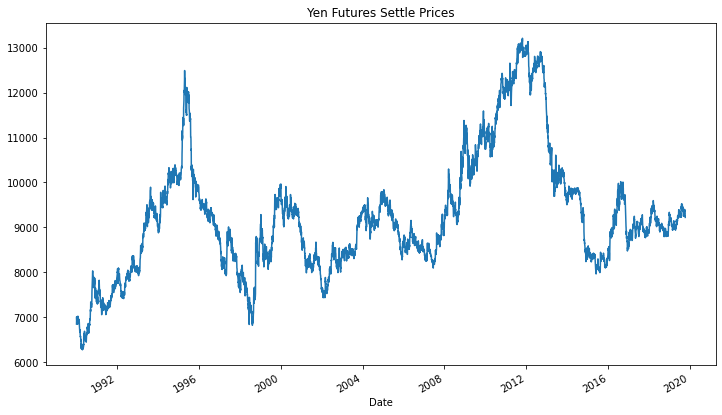

In [4]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!

yen_futures["Settle"].plot(figsize=(12,7),title= 'Yen Futures Settle Prices')

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!

settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!

settle_df= pd.DataFrame(yen_futures["Settle"])
settle_df['noise']= settle_noise
settle_df['trend']= settle_trend
settle_df.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle vs Trend'}, xlabel='Date'>

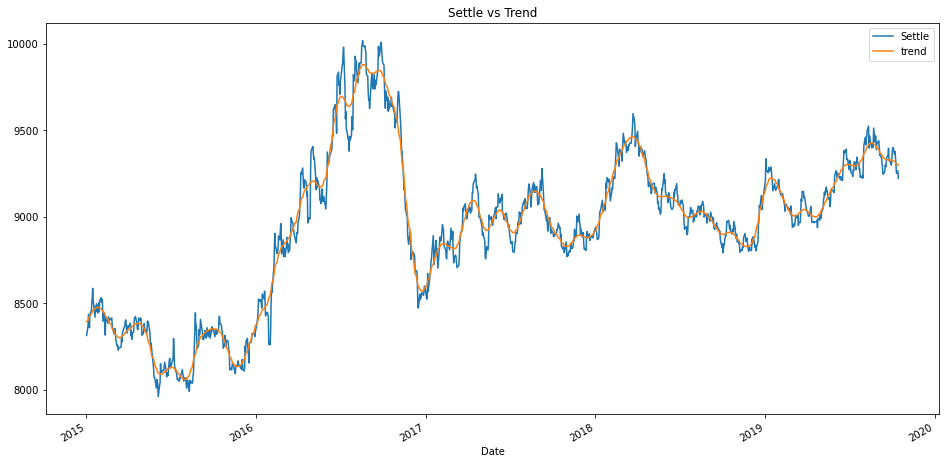

In [7]:
# Plot the Settle Price vs. the Trend
# YOUR CODE HERE!

sliced_df = settle_df.loc["2015":"2019"]
sliced_df.plot(y=["Settle", "trend"], figsize = (16,8), title= 'Settle vs Trend')

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

<AxesSubplot:title={'center':'Settle Noise'}, xlabel='Date'>

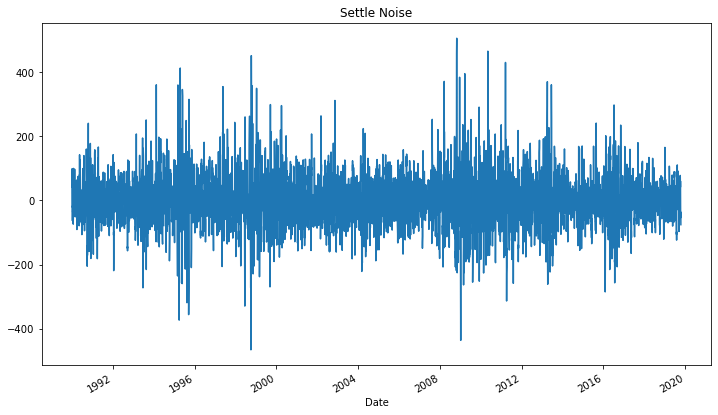

In [8]:
# Plot the Settle Noise
# YOUR CODE HERE!

settle_noise.plot(figsize=(12,7),title='Settle Noise')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [10]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model=ARMA(returns.Settle,order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results=model.fit()


In [11]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 15 Dec 2022   AIC                          15798.142
Time:                        12:15:29   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3063      1.277     -0.240      0.810      -2.809       2.196
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2948      1.277      0.231      0.817      -2.207       2.797
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3335           +0.0000j            3.3335            0.5000
AR.2         -157.2377           +0.0000j          157.2377            0.5000
MA.1           -3.3924           +0.0000j            3.3924            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

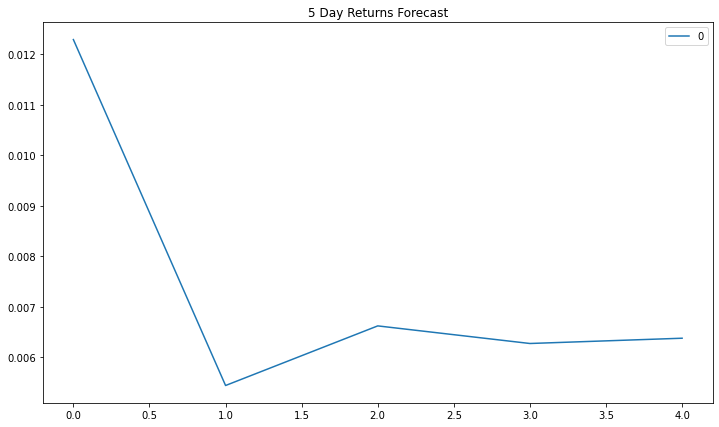

In [12]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!

pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(12,7),title="5 Day Returns Forecast")

Question: Based on the p-value, is the model a good fit?

Answer: Since, p-values are greater than 0.05, hence it can be said the ARMA model doesn't seem a good fit. 

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

arima_model = ARIMA(settle_df['Settle'], order=(5, 1, 1))

# Fit the model
# YOUR CODE HERE!
results_arima = arima_model.fit()

In [14]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 15 Dec 2022   AIC                          83905.238
Time:                        12:15:31   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2821      0.699      0.403      0.687      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.065      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2971      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8916           -1.3786j            2.3406           -0.1002
AR.2            1.8916           +1.3786j            2.3406            0.1002
AR.3           -2.2688           -3.0220j            3.7789           -0.3525
AR.4           -2.2688           +3.0220j            3.7789            0.3525
AR.5          -11.0241           -0.0000j           11.0241           -0.5000
MA.1            3.3658           +0.0000j            3.3658            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

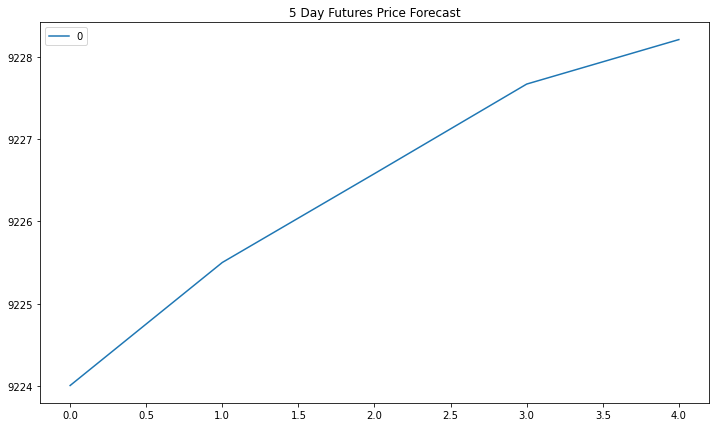

In [15]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!

pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(figsize=(12,7),title="5 Day Futures Price Forecast")

What does the model forecast will happen to the Japanese Yen in the near term?

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
import arch as arch
from arch import arch_model

In [17]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model_garch = arch_model(returns['Settle'], mean="Zero", vol="GARCH", p=2, q=1) 

# Fit the model
# YOUR CODE HERE!

results_garch = model_garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 87406254.62884925
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8220.925448485285
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7487.715051647085
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7505.8233985962215
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.046068867134
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7895.737484233749
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7462.4113697930225
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7462.2146776534555
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7462.021535648443
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935930634227
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7461.927898024664
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7461.927643351801
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7461.927640221216
Iteration:     14,   Func. Count:     82,   Neg. LLF: 4239912

In [18]:
# Summarize the model results
# YOUR CODE HERE!

results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Thu, Dec 15 2022   Df Residuals:                     7514
Time:                        12:15:32   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!

forecasts = results_garch.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

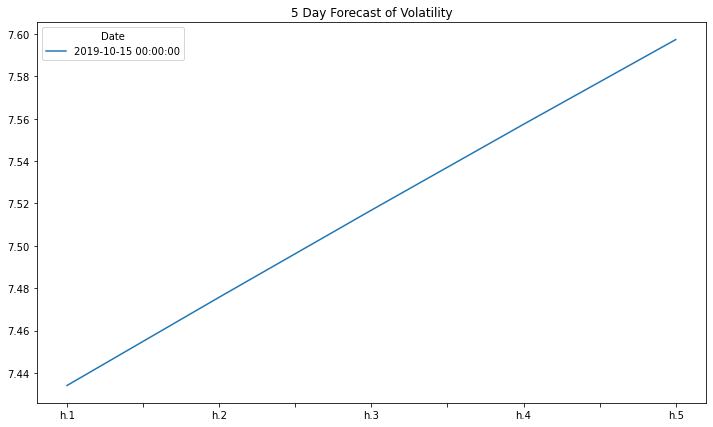

In [23]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(figsize=(12,7),title="5 Day Forecast of Volatility")

---

# Conclusions

###### Based on your time series analysis, would you buy the yen now?

Answer: Yes because we see the futures price forecast has a increasing trend. Hence, we can buy for short term.


###### Is the risk of the yen expected to increase or decrease?

Answer: Increase. As we can see from GARCH model, there is an increasing trend in the volitality.


###### Based on the model evaluation, would you feel confident in using these models for trading?

Answer: Yes.Based on all models done above, majority of the models suggest to buy the Yen. Hence, we are confident about using these models for training.